In [15]:
import numpy as np
import torch
import pandas as pd
import os
import csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import sklearn as sk
import torch
from torch.utils.data import Dataset
import statsmodels.api as sm
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline
!python --version

Python 3.7.13


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: beserkbear
Your Kaggle Key: ··········


100%|██████████| 3.03M/3.03M [00:00<00:00, 107MB/s]

In [4]:
# opening the CSV file
with open('/content/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # # displaying the contents of the CSV file
  # for lines in csvFile:
  #       print(lines)



df = pd.read_csv('/content/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv', 
                 index_col='Date',
                 usecols = ['Date','Open', 'High','Low','Close','Volume'])

print(df.shape)
df = df.dropna()
print(df)
print(df.iloc[:,1:2].values)


(3019, 5)
               Open     High      Low    Close    Volume
Date                                                    
2006-01-03   211.47   218.05   209.32   217.83  13137450
2006-01-04   222.17   224.70   220.09   222.84  15292353
2006-01-05   223.22   226.00   220.97   225.85  10815661
2006-01-06   228.66   235.49   226.85   233.06  17759521
2006-01-09   233.44   236.94   230.70   233.68  12795837
...             ...      ...      ...      ...       ...
2017-12-22  1070.00  1071.72  1067.64  1068.86    889446
2017-12-26  1068.64  1068.86  1058.64  1065.85    918767
2017-12-27  1066.60  1068.27  1058.38  1060.20   1116203
2017-12-28  1062.25  1064.84  1053.38  1055.95    994249
2017-12-29  1055.49  1058.05  1052.70  1053.40   1180340

[3019 rows x 5 columns]
[[ 218.05]
 [ 224.7 ]
 [ 226.  ]
 ...
 [1068.27]
 [1064.84]
 [1058.05]]


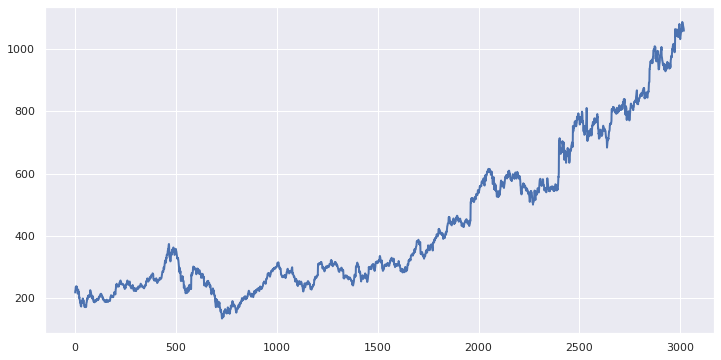

In [5]:
training_set = df.iloc[:,1:2].values
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=training_set, linewidth=2, ax=ax, legend=None)

In [6]:
def sliding_windows_DataLoader(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

sc = MinMaxScaler() #scale each feature to a range
training_data = sc.fit_transform(training_set) #fits to data and then transforms

seq_length = 6
x, y = sliding_windows_DataLoader(training_data, seq_length)
print(len(y))

train_size = int(len(y) * 0.75)
test_size = len(y) - train_size
print('train_size:',train_size,' test_size:',test_size)


dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))


trainX, trainY = torch.Tensor(np.array(x[0:train_size])), torch.Tensor(np.array(y[0:train_size]))
testX, testY = torch.Tensor(np.array(x[train_size:len(x)])), torch.Tensor(np.array(y[train_size:len(y)]))


3013
train_size: 2259  test_size: 754


In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

        self.last = torch.Tensor(0)
    def forward(self, x):
        
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)        
        out = self.fc(h_out)
        self.last = out.clone()
        return out

In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

        self.last = torch.Tensor(0)
    def forward(self, x):
        
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)        
        out = self.fc(h_out)
        self.last = out.clone()
        return out

In [18]:
num_epochs = 2500
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01567
Epoch: 20, loss: 0.00560
Epoch: 40, loss: 0.00016
Epoch: 60, loss: 0.00015
Epoch: 80, loss: 0.00007
Epoch: 100, loss: 0.00007
Epoch: 120, loss: 0.00006
Epoch: 140, loss: 0.00006
Epoch: 160, loss: 0.00006
Epoch: 180, loss: 0.00006
Epoch: 200, loss: 0.00006
Epoch: 220, loss: 0.00006
Epoch: 240, loss: 0.00006
Epoch: 260, loss: 0.00007
Epoch: 280, loss: 0.00006
Epoch: 300, loss: 0.00006
Epoch: 320, loss: 0.00006
Epoch: 340, loss: 0.00006
Epoch: 360, loss: 0.00006
Epoch: 380, loss: 0.00006
Epoch: 400, loss: 0.00006
Epoch: 420, loss: 0.00006
Epoch: 440, loss: 0.00006
Epoch: 460, loss: 0.00006
Epoch: 480, loss: 0.00006
Epoch: 500, loss: 0.00006
Epoch: 520, loss: 0.00012
Epoch: 540, loss: 0.00006
Epoch: 560, loss: 0.00005
Epoch: 580, loss: 0.00005
Epoch: 600, loss: 0.00005
Epoch: 620, loss: 0.00005
Epoch: 640, loss: 0.00005
Epoch: 660, loss: 0.00005
Epoch: 680, loss: 0.00005
Epoch: 700, loss: 0.00005
Epoch: 720, loss: 0.00005
Epoch: 740, loss: 0.00005
Epoch: 760, loss: 

In [10]:
with torch.no_grad():
  lstm.eval()
  train_predict = lstm(dataX)

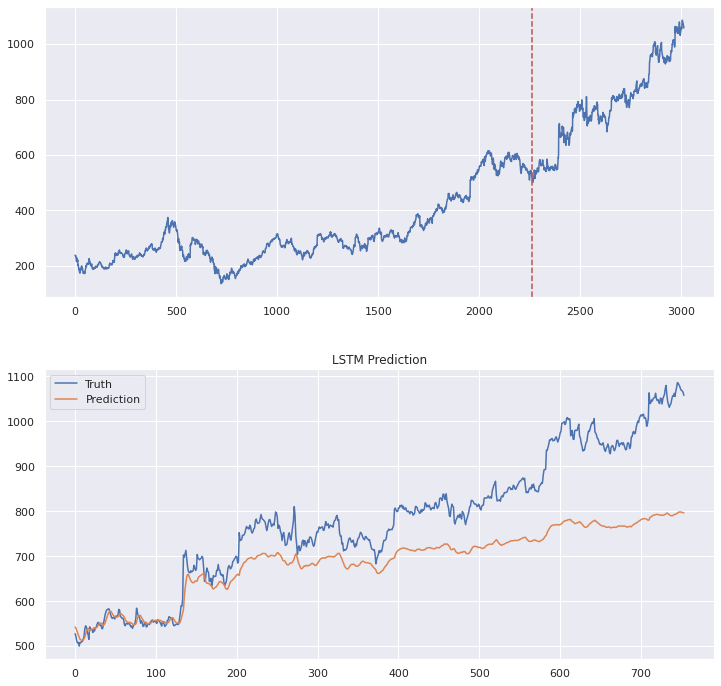

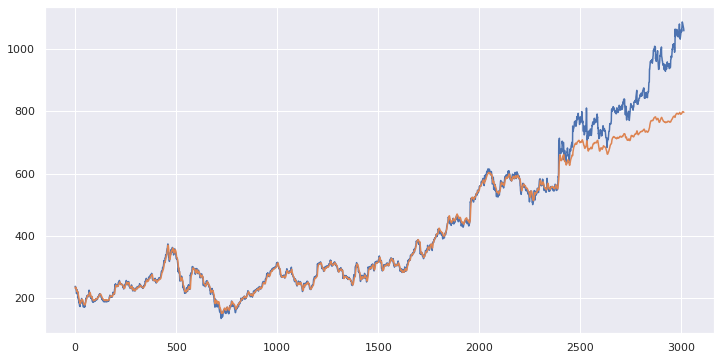

MSE: 14353.706055


In [22]:
data_predict = sc.inverse_transform(train_predict.data.numpy())
data_GroundTruth = sc.inverse_transform(dataY.data.numpy())

fig, ax = plt.subplots(2,1,figsize=(12, 12))


ax[0].plot(data_GroundTruth)
ax[0].axvline(x=train_size, c='r', linestyle='--')

ax[1].plot(data_GroundTruth[-test_size:])
ax[1].plot(data_predict[-test_size:])
ax[1].legend(["Truth", "Prediction"])
ax[1].set_title('LSTM Prediction')
plt.subplots_adjust(hspace = 0.25)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data_GroundTruth)
plt.plot(data_predict)
plt.show()
# print((data_predict[-test_size:]-data_GroundTruth[-test_size:]).shape)
# plot_acf(np.diff((data_predict[-test_size:]-data_GroundTruth[-test_size:]).flatten()))
# plot_acf(np.diff(data_predict[-test_size:]-data_GroundTruth[-test_size:]))
# print(durbin_watson(data_predict[-test_size:]-data_GroundTruth[-test_size:]))

plt.show()

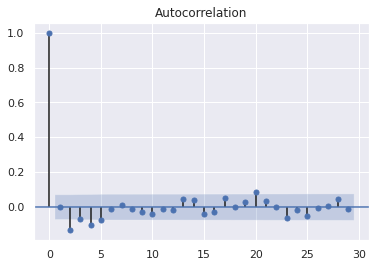


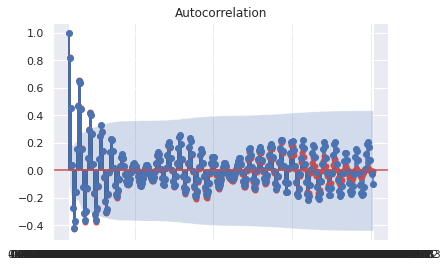

In [12]:
def correlation(x, y):
  n = np.size(x)
  num = (n*np.sum(np.multiply(x,y))) - (np.sum(x)*np.sum(y))
  den = ((n*np.sum(np.square(x)) - (np.sum(x))**2) * (n*np.sum(np.square(y)) - (np.sum(y))**2))**0.5
  return float(num/den)

def autocorrelation(x, shifts):
  n = np.size(x)
  out = np.empty(shifts+1)
  for shift in range(shifts+1):
    co = correlation(x[:n-shift], x[shift:])*np.exp(-0.005*shift)
    out[shift] = co
  plt.stem(out, use_line_collection = True, linefmt = '1')
  plt.xticks(np.arange(shifts+1), out)
  plt.show()

'''else, if the graph is too stuffy, use this function instead, sampled every five, on you ma'am

def autocorrelation(x, shifts):
  n = np.size(x)
  out = np.empty(shifts+1)
  for shift in range(0, shifts+1, 5):
    co = correlation(x[:n-shift], x[shift:])
    out[shift] = co
  plt.figure(figsize=(14, 8))
  plt.stem(out, use_line_collection = True, basefmt=" ")
  plt.xticks(np.arange(0, shifts+1, 5), out)
  plt.show()'''

dta = sm.datasets.sunspots.load_pandas().data  
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=300, color = 'r')
autocorrelation(dta.values, 300)

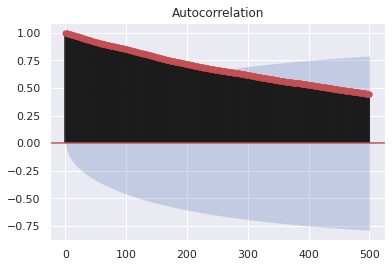

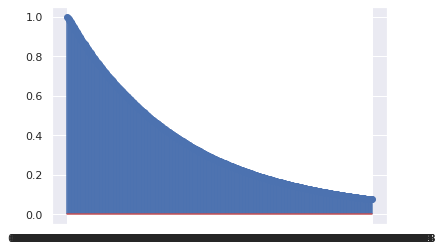

In [13]:

plot_acf(df['Open'].values.squeeze(), lags = 500, color = 'r')
plt.show()
autocorrelation(df['Open'].values, 500)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


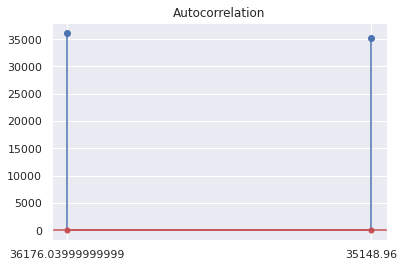

In [14]:
from scipy.fft import fft, ifft

def correlation(x, y):
  X = fft(x)
  Y = fft(y)
  Yconj = np.conjugate(Y)
  ans = ifft(X*Yconj)
  return np.max(ans)
  

def autocorrelation(x, shifts):
  n = np.size(x)
  out = np.empty(shifts+1)
  for shift in range(shifts+1):
    co = correlation(x[:n-shift], x[shift:])
    out[shift] = co
  plt.stem(out, use_line_collection = True, linefmt = '1')
  plt.xticks(np.arange(shifts+1), out)
  plt.show()

dta = sm.datasets.sunspots.load_pandas().data  
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=1, color = 'r')
autocorrelation(dta.values, 1)